# <center>  2024S_AML-3104_ Final Project: Face Recognation - Attandance System </center>

# Team Members:
- Bhavya Vadher (c0894977)
- Viki Patel (c0894966)
- Devarsh Jadhav (c0894965)
- Syed Roman (c0894964)

## Importing Libraries

In [59]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from IPython.display import Image
from tensorflow.keras.utils import register_keras_serializable
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense,BatchNormalization
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import os
import pickle
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from keras_facenet import FaceNet
import tensorflow as tf
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from mtcnn import MTCNN

# Model 1

In [49]:
# Path to the original dataset directory
original_dataset_dir = 'finaldataset'

# Paths to the new directories
train_dir = 'TrainTest/train'
test_dir = 'TrainTest/test'

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    
    if os.path.isdir(class_dir):
        # List all image file names and filter out directories
        images = [img for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))]
        
        # Debugging: Print out the list of images found
        print(f"Class: {class_name}, Found {len(images)} images.")
        
        if len(images) == 0:
            print(f"No images found in class {class_name}. Skipping this class.")
            continue  # Skip to the next class if no images are found
        
        # Split the images into training and testing sets (80-20)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        
        # Create class directories in train and test folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Copy training images
        for image in train_images:
            src_path = os.path.join(class_dir, image)
            dest_path = os.path.join(train_dir, class_name, image)
            shutil.copy(src_path, dest_path)
        
        # Copy testing images
        for image in test_images:
            src_path = os.path.join(class_dir, image)
            dest_path = os.path.join(test_dir, class_name, image)
            shutil.copy(src_path, dest_path)

print("Dataset successfully split into training and testing sets.")


Class: ronak, Found 600 images.
Class: bhavya, Found 600 images.
Class: ramandeep, Found 600 images.
Class: rehan, Found 600 images.
Class: shubham, Found 600 images.
Class: yash, Found 600 images.
Class: zoeb, Found 600 images.
Class: nagasai, Found 600 images.
Dataset successfully split into training and testing sets.


In [50]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'TrainTest/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'TrainTest/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 3840 files belonging to 8 classes.
Found 960 files belonging to 8 classes.


In [51]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [60]:
input_layer = Input(shape=(150, 150, 3))

# Block 1
x = Conv2D(32, (5, 5), activation='relu', padding='same', name='block1_conv1')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

# Flatten and apply dropout
x = Flatten()(x)
x = Dropout(0.5)(x)  # Dropout layer with a 50% drop rate
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer with a 50% drop rate
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer with a 50% drop rate
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer with a 50% drop rate
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer with a 50% drop rate

# Output layer (for example, for 8 classes)
output_layer = Dense(8, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
model.summary()


Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 256)      │             

 Total params: 49,314,344 (188.12 MB)

 Trainable params: 49,310,376 (188.10 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [61]:
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [63]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.1666 - loss: 2.9938 - val_accuracy: 0.1250 - val_loss: 2.9737
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.2530 - loss: 2.2520 - val_accuracy: 0.1250 - val_loss: 3.5494
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.3358 - loss: 1.8721 - val_accuracy: 0.1250 - val_loss: 3.4127
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.4074 - loss: 1.6561 - val_accuracy: 0.4635 - val_loss: 1.4034
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.5189 - loss: 1.3435 - val_accuracy: 0.6708 - val_loss: 0.9786
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.5978 - loss: 1.0965 - val_accuracy: 0.5052 - val_loss: 1.4026
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.6538 - loss: 0.9436 - val_accuracy: 0.7750 - val_loss: 0.5816
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.6959 - loss: 0.8447 - val_accu

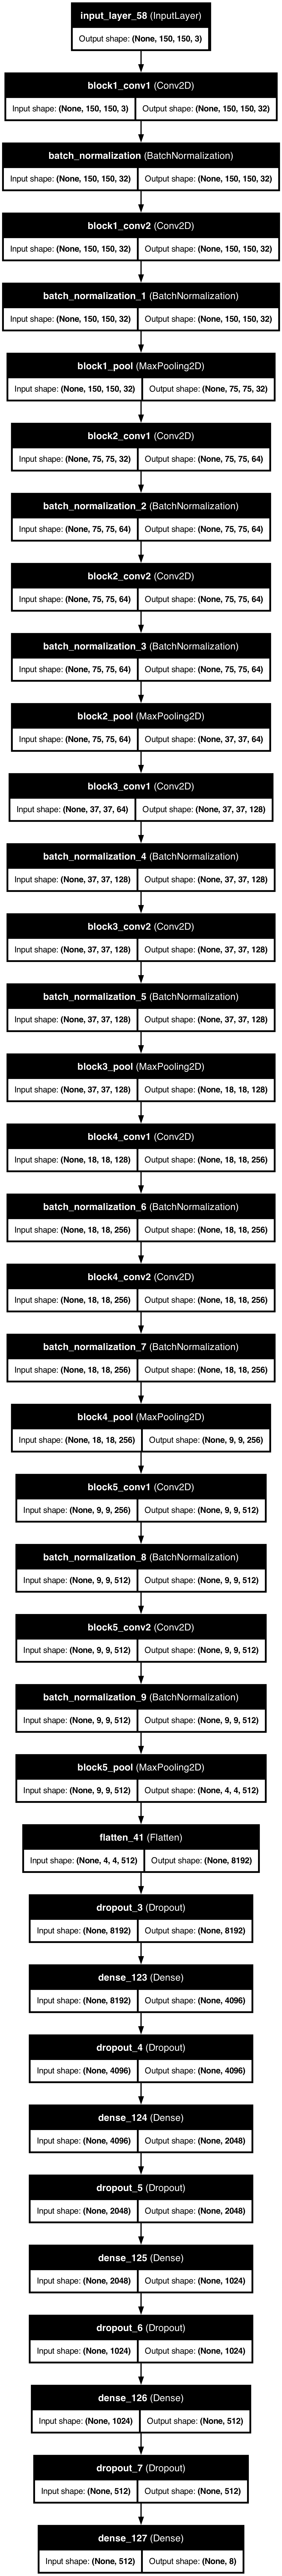

In [64]:
# Create a plot of the model architecture
plot_model(model, to_file='Model1.png', show_shapes=True, show_layer_names=True)
Image(filename='Model1.png')

In [65]:
model.save('Model1.keras')

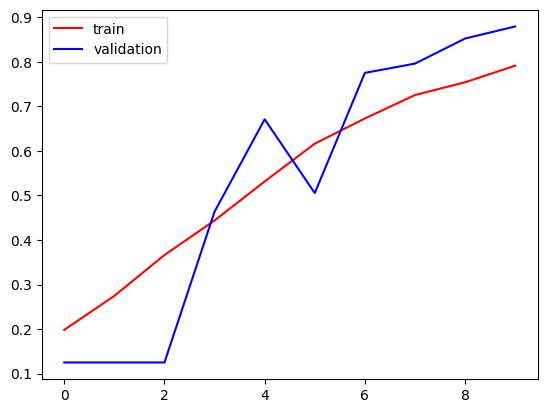

In [66]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

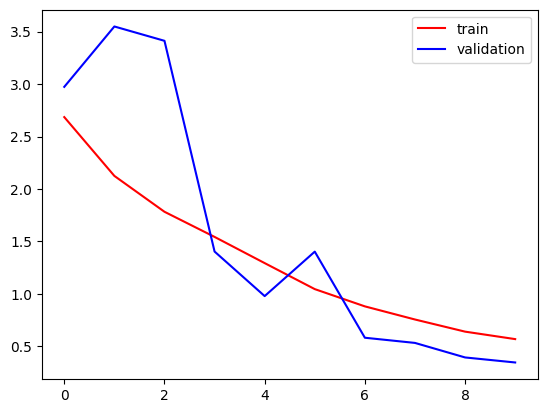

In [67]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Detected Student: ramandeep


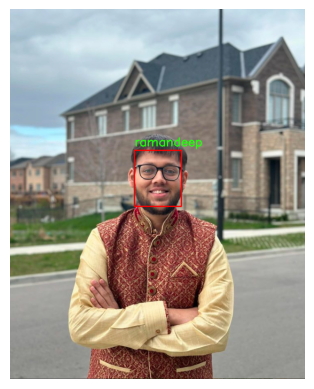

In [74]:
model = load_model('Model1.keras')

# Path to the dataset directories to get class names
train_directory = '/Users/bhavyavadher/Desktop/SEM 3/DeepLearning/facenet_student_model_100/finaldataset/train'

# Extract class names from the directory structure
class_names = sorted(os.listdir(train_directory))

# Initialize MTCNN face detector
detector = MTCNN()

# Path to the new image for prediction
image_path = 'Screenshot 2024-08-05 191635.png'
image = cv2.imread(image_path)

# Check if image is valid
if image is None:
    print("Failed to load image. Please check the file path.")
else:
    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Detect faces using MTCNN
    detections = detector.detect_faces(image)

    if len(detections) == 0:
        print("No faces detected.")
    else:
        for detection in detections:
            # Extract bounding box coordinates
            x, y, width, height = detection['box']
            
            # Extract the face and resize it to match the model's input size
            face = image[y:y+height, x:x+width]
            face = cv2.resize(face, (150, 150))  # Assuming 150x150 input size as per your data generator
            face = face.astype('float32') / 255.0  # Normalize the image to [0,1] range
            face = np.expand_dims(face, axis=0)    # Add batch dimension
            
            # Make a prediction using the model
            prediction = model.predict(face)
            predicted_class_idx = np.argmax(prediction, axis=1)[0]
            
            # Map the predicted index back to the corresponding class name
            student_name = class_names[predicted_class_idx]
            
            print(f"Detected Student: {student_name}")
            
            # Draw a rectangle around the face and display the name
            cv2.rectangle(image_rgb, (x, y), (x+width, y+height), (255, 0, 0), 2)
            cv2.putText(image_rgb, student_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

        # Display the image with bounding boxes and predictions using matplotlib
        plt.imshow(image_rgb)
        plt.axis('off')  # Hide axes
        plt.show()


This model is not working very well so tried with other models

# Model 2

In [20]:
# Load the pre-trained FaceNet model
facenet_model = FaceNet().model

# Freeze the layers in the base FaceNet model
for layer in facenet_model.layers:
    layer.trainable = False

# Add custom layers for your specific classification task (8 students)
x = Flatten()(facenet_model.output)
x = Dense(128, activation='relu')(x)
output_layer = Dense(8, activation='softmax')(x)  # Assuming 8 students

# Create the full model
model2 = Model(inputs=facenet_model.input, outputs=output_layer)

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Path to your dataset
data_dir = 'finaldataset'

# Initialize lists to hold the data and labels
data = []
labels = []

# Image dimensions for FaceNet
img_size = 160

# Load and preprocess images
for student_folder in os.listdir(data_dir):
    student_path = os.path.join(data_dir, student_folder)
    if os.path.isdir(student_path):
        for image_name in os.listdir(student_path):
            image_path = os.path.join(student_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (img_size, img_size))
            image = image.astype('float32') / 255.0
            data.append(image)
            labels.append(student_folder)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [24]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

datagen.fit(X_train)

# Early stopping and learning rate reduction callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model2.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=10,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 45s 348ms/step - accuracy: 0.1596 - loss: 2.0733 - val_accuracy: 0.2969 - val_loss: 2.0410 - learning_rate: 1.0000e-04
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 45s 374ms/step - accuracy: 0.2992 - loss: 2.0303 - val_accuracy: 0.3552 - val_loss: 1.9958 - learning_rate: 1.0000e-04
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 46s 376ms/step - accuracy: 0.3249 - loss: 1.9858 - val_accuracy: 0.3781 - val_loss: 1.9469 - learning_rate: 1.0000e-04
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 46s 382ms/step - accuracy: 0.3526 - loss: 1.9383 - val_accuracy: 0.3760 - val_loss: 1.8949 - learning_rate: 1.0000e-04
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 47s 387ms/step - accuracy: 0.3678 - loss: 1.8950 - val_accuracy: 0.3760 - val_loss: 1.8523 - learning_rate: 1.0000e-04
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 48s 398ms/step - accuracy: 0.3644 - loss: 1.8498 - val_accuracy: 0.3917 - val_loss: 1.8105 - learning_rate: 1.0000e-04
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 52s 431ms/step - 

In [26]:
# Create a plot of the model architecture
plot_model(model2, to_file='Facenet.png', show_shapes=True, show_layer_names=True)
Image(filename='Facenet.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.293364 to fit



In [27]:
model2.save('Model2_FaceNet.keras')

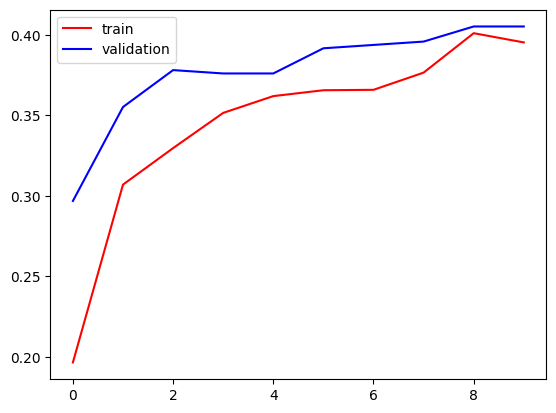

In [30]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

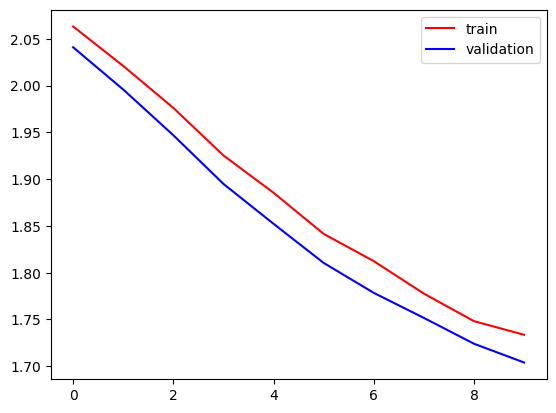

In [31]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
Detected Student: bhavya


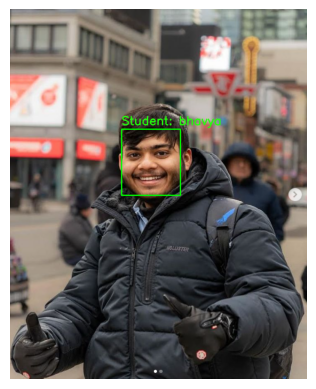

In [47]:
@register_keras_serializable()
def scaling(x, **kwargs):  # Modified to accept additional arguments
    return x / 255.0

@register_keras_serializable()
def l2_normalize(x, axis=None):
    return tf.keras.backend.l2_normalize(x, axis=axis)

# Load the model (choose either the .h5 or .keras file)
# If using the .h5 format:
# model = load_model('facenet_student_model_100.h5', custom_objects={'scaling': scaling, 'l2_normalize': l2_normalize})

# If using the .keras format:
model = load_model('facenet_student_model_100.keras', custom_objects={'scaling': scaling, 'l2_normalize': l2_normalize})

# Load the label encoder
with open('label_encoder_100.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# Initialize MTCNN face detector
detector = MTCNN()

# Path to the image you want to detect and predict
image_path = 'Screenshot 2024-08-05 191556.png'
image = cv2.imread(image_path)

# Convert image from BGR to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect faces using MTCNN
detections = detector.detect_faces(image)

for detection in detections:
    x, y, width, height = detection['box']
    x, y, width, height = int(x), int(y), int(width), int(height)
    
    # Draw rectangle around the face
    cv2.rectangle(image_rgb, (x, y), (x + width, y + height), (0, 255, 0), 2)
    
    # Extract and preprocess the face
    face = image[y:y + height, x:x + width]
    face = cv2.resize(face, (160, 160))
    face = face.astype('float32') / 255.0
    face = np.expand_dims(face, axis=0)
    
    # Predict the student using the loaded model
    prediction = model.predict(face)
    predicted_class = np.argmax(prediction, axis=1)[0]
    student_name = label_encoder.inverse_transform([predicted_class])[0]
    
    # Add label to the image
    label = f"Student: {student_name}"
    cv2.putText(image_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
    
    print(f"Detected Student: {student_name}")

# Display the image with matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis
plt.show()

# Model 3

In [2]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

In [3]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [4]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

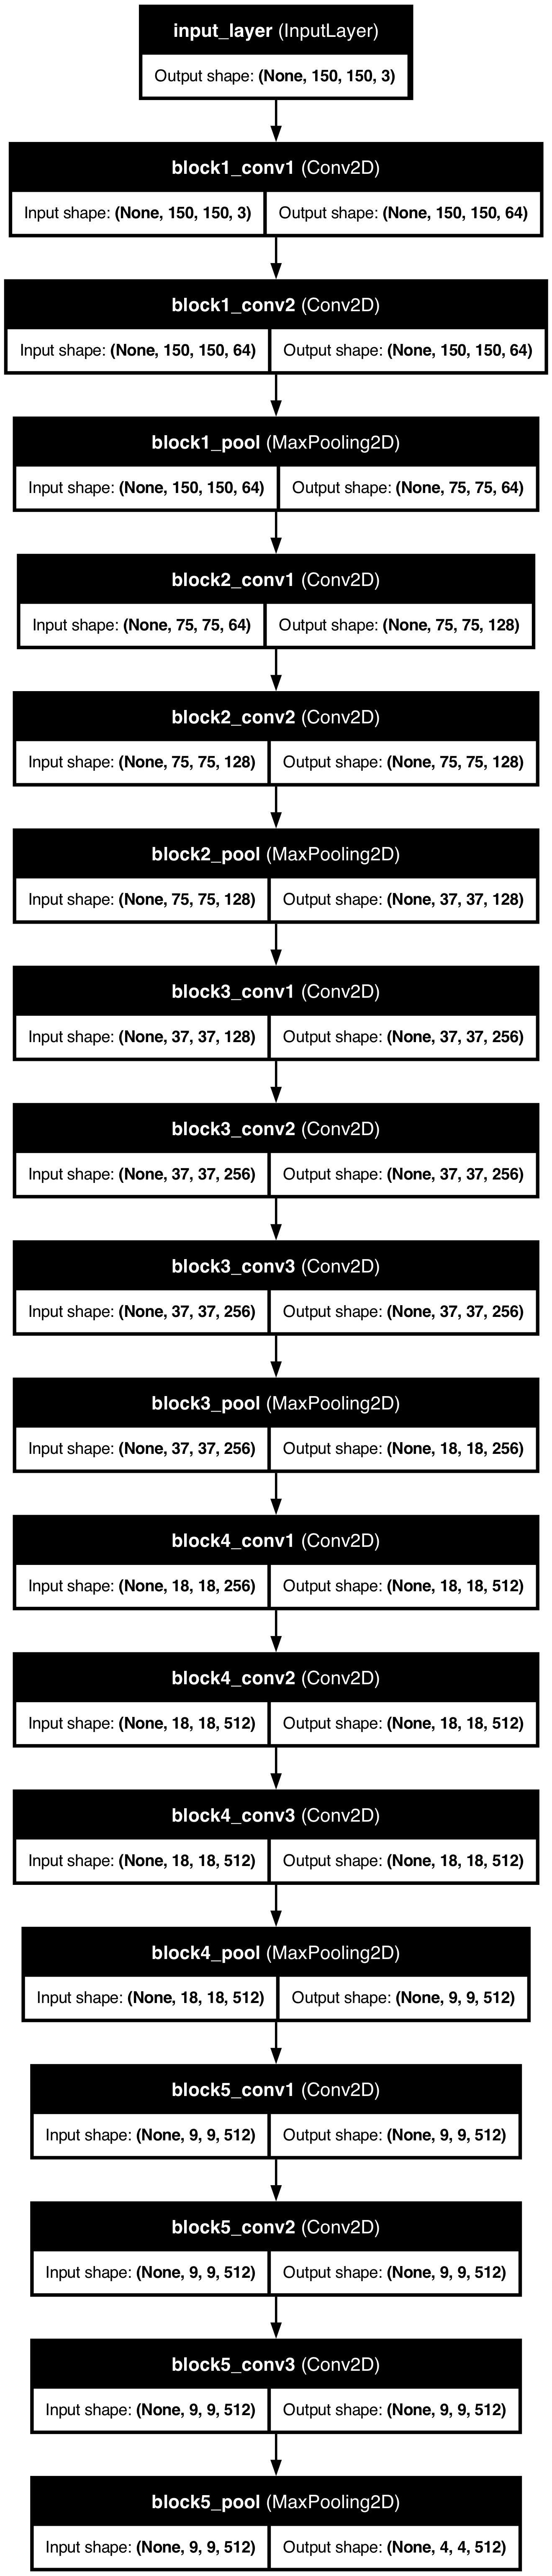

In [9]:
plot_model(conv_base, to_file='base_VGG.png', show_shapes=True, show_layer_names=True)
Image(filename='base_VGG.png')

In [10]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(8,activation='softmax'))

In [13]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [14]:
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [10]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.6973 - loss: 0.8669 - val_accuracy: 0.9563 - val_loss: 0.1344
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.9757 - loss: 0.0807 - val_accuracy: 0.9646 - val_loss: 0.0952
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.9872 - loss: 0.0400 - val_accuracy: 0.9729 - val_loss: 0.0709
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.9814 - loss: 0.0514 - val_accuracy: 0.9771 - val_loss: 0.0731
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.9854 - loss: 0.0400 - val_accuracy: 0.9698 - val_loss: 0.0841
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - accuracy: 0.9849 - loss: 0.0495 - val_accuracy: 0.9719 - val_loss: 0.0745
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.9917 - loss: 0.0242 - val_accuracy: 0.9750 - val_loss: 0.0984
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.9909 - loss: 0.0224 - val_accu

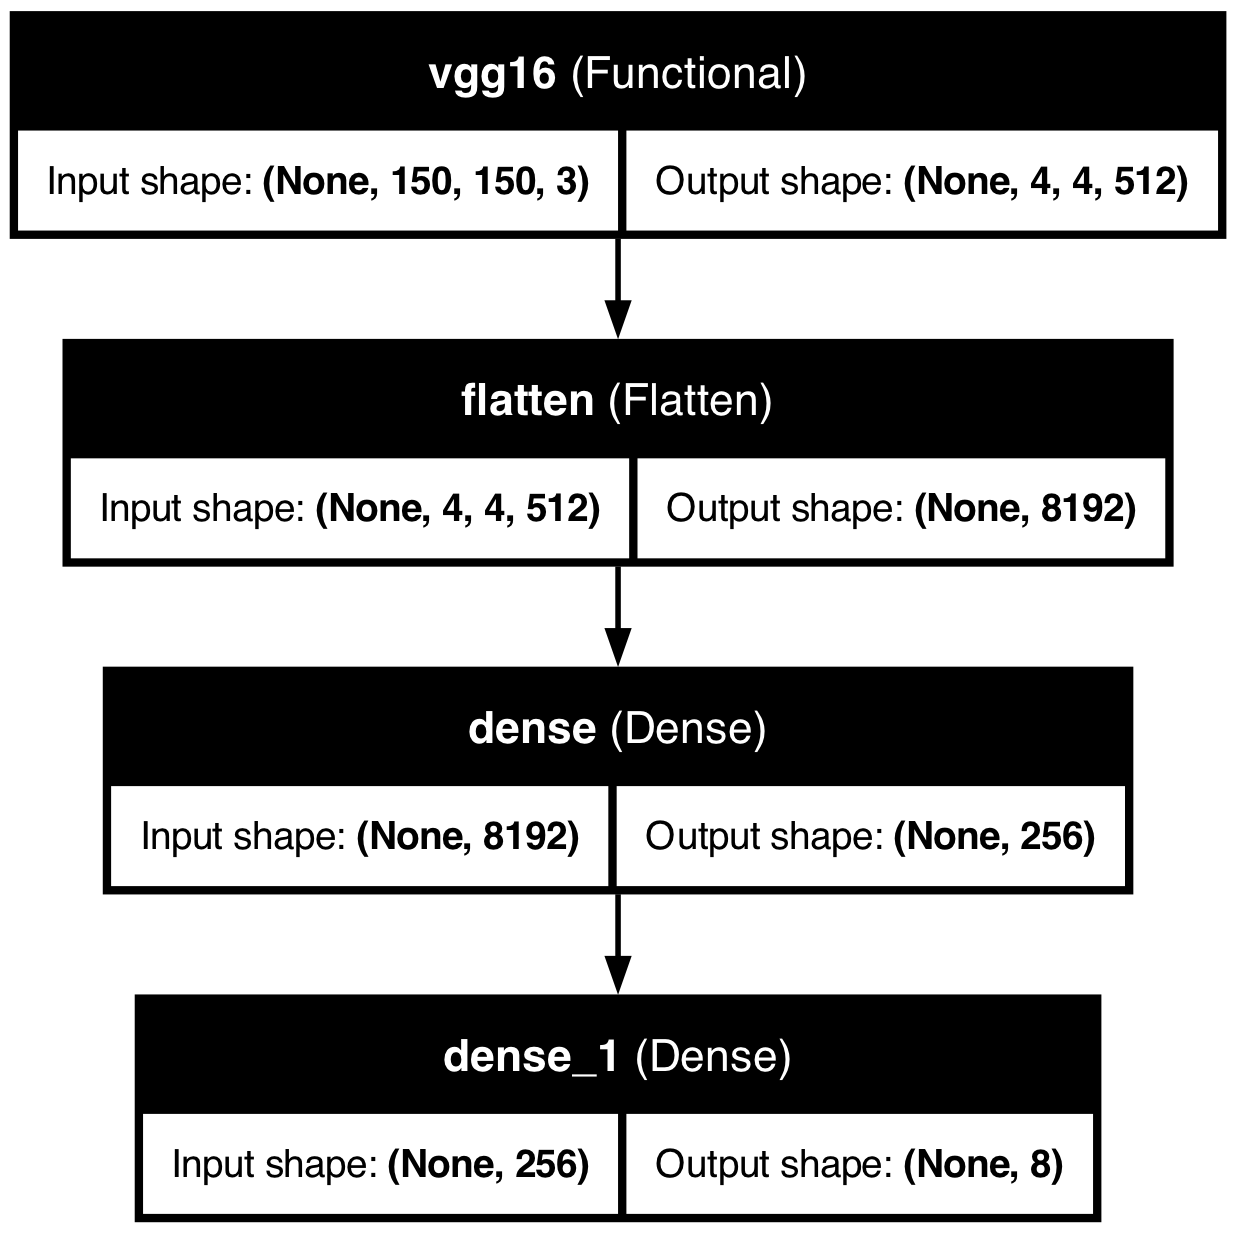

In [8]:
# Create a plot of the model architecture
plot_model(model, to_file='VGG16.png', show_shapes=True, show_layer_names=True)
Image(filename='VGG16.png')

In [22]:
model.save('Model3_VGG16.keras')

In [24]:
model_path = os.path.abspath('Model3_VGG16.keras')

print(f"Model saved at: {model_path}")

Model saved at: /Users/bhavyavadher/Desktop/DL/Transfer Learning/Model3_VGG16.keras


In [23]:
# Load the entire model from the HDF5 file.
model = load_model('Model3_VGG16.keras')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


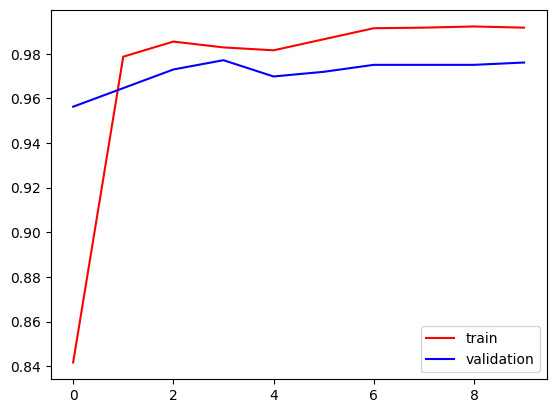

In [15]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

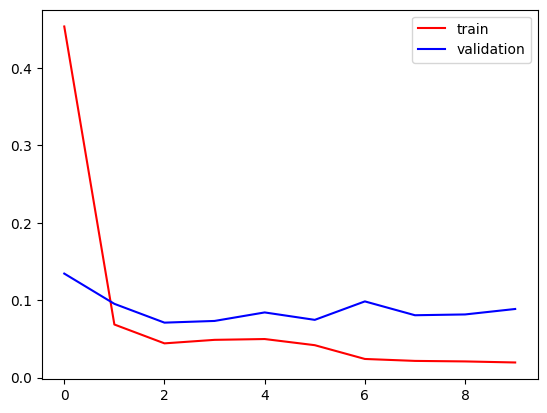

In [16]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [19]:
image = cv2.imread('/Users/bhavyavadher/Desktop/SEM 3/DeepLearning/facenet_student_model_100/IMG_5276.JPG')

if image is None:
    print("Failed to load image. Please check the file path.")
else:
    # Proceed with face detection
    detections = detector.detect_faces(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Detected Student: nagasai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Detected Student: yash


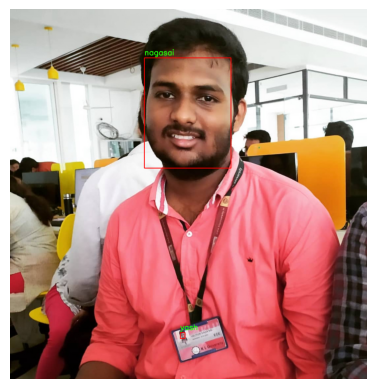

In [17]:
model = load_model('Model3_VGG16.h5')

# Path to the dataset directories to get class names
train_directory = '/Users/bhavyavadher/Desktop/SEM 3/DeepLearning/facenet_student_model_100/finaldataset/train'

# Extract class names from the directory structure
class_names = sorted(os.listdir(train_directory))

# Initialize MTCNN face detector
detector = MTCNN()

# Path to the new image for prediction
image_path = 'nagasai.jpeg'
image = cv2.imread(image_path)

# Check if image is valid
if image is None:
    print("Failed to load image. Please check the file path.")
else:
    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Detect faces using MTCNN
    detections = detector.detect_faces(image)

    if len(detections) == 0:
        print("No faces detected.")
    else:
        for detection in detections:
            # Extract bounding box coordinates
            x, y, width, height = detection['box']
            
            # Extract the face and resize it to match the model's input size
            face = image[y:y+height, x:x+width]
            face = cv2.resize(face, (150, 150))  # Assuming 150x150 input size as per your data generator
            face = face.astype('float32') / 255.0  # Normalize the image to [0,1] range
            face = np.expand_dims(face, axis=0)    # Add batch dimension
            
            # Make a prediction using the model
            prediction = model.predict(face)
            predicted_class_idx = np.argmax(prediction, axis=1)[0]
            
            # Map the predicted index back to the corresponding class name
            student_name = class_names[predicted_class_idx]
            
            print(f"Detected Student: {student_name}")
            
            # Draw a rectangle around the face and display the name
            cv2.rectangle(image_rgb, (x, y), (x+width, y+height), (255, 0, 0), 2)
            cv2.putText(image_rgb, student_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

        # Display the image with bounding boxes and predictions using matplotlib
        plt.imshow(image_rgb)
        plt.axis('off')  # Hide axes
        plt.show()
